In [107]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from helper_functions import *

In [161]:
class CreateAirlineSimulation():
    
    def __init__(self, demand_set_price=None, demand_exp_factor=None, price_sensitivity_factor=None, 
                 competitiveness_score=None, our_stock=80, comp_stock=80):
        """
        Class is used to simulate the demand for flight tickets.

        Attributes:
            demand_set_price: Starting/opening price which would result in lambda 1 (~1 demand when prices are all equal)
            demand_exp_factor: Exponential factor that increases the price demand every period
            price_sensitivity_factor: How important pricing is in demand for this season
            competitiveness_score: How importance price difference with competitor is for this season
        """
        self.period = 1
        self.our_stock = our_stock
        self.comp_stock = comp_stock
        self.demand_set_price = demand_set_price
        self.demand_exp_factor = demand_exp_factor
        self.price_sensitivity_factor = price_sensitivity_factor
        self.competitiveness_score = competitiveness_score
        self.demand_curve_prices = []
        self._initialize_demand_curve()
    
    def _initialize_demand_curve(self):
        """
        Initialize demand curve and environment characteristics.
        """
        
        if self.demand_set_price is None:
            self.demand_set_price = np.random.normal(50, 10)
            
        if self.demand_exp_factor is None:
            self.demand_exp_factor = np.random.normal(1.005, 0.001)
            
        if self.price_sensitivity_factor is None:
            self.price_sensitivity_factor = np.random.normal(1.1, 0.05)
            
        if self.competitiveness_score is None:
            self.competitiveness_score = np.random.normal(1.1, 0.05)
        
        self.demand_curve_prices = np.array([
            self.exp_increase(self.demand_set_price, self.demand_exp_factor, x) for x in range(1, 101)
        ])
    
    @staticmethod
    def exp_increase(start_point, exp_inc, timestep):
        """
        Calculates exponential increase based on timestep.
        """
        return start_point * exp_inc**(timestep-1)
    
    @staticmethod
    def calculate_lambdas(demand_set_price, our_price, comp_price, price_sensitivity_factor, competitiveness_score):
        """
        Given your price, and the price of competitor, you will pull demand from a certain distribution.
        The distribution is a poisson distribution which uses lambda as input to determine the distribution.

        Lambda must be a relative score depending on:
        Our prices relative to demand curve
        Our price relative to competition
        Price sensitivity of market (price elastivity)
        Competitiveness of the market
        """

        # Set lambda based on price diff with set price
        our_lambda = 1 + (demand_set_price - our_price) / our_price
        comp_lambda = 1 + (demand_set_price - comp_price) / comp_price

        # Adjust for price sensitivity
        if our_price > demand_set_price:
            our_lambda = our_lambda / price_sensitivity_factor
        else:
            our_lambda = our_lambda * price_sensitivity_factor

        if comp_price > demand_set_price:
            comp_lambda = comp_lambda / price_sensitivity_factor
        else:
            comp_lambda = comp_lambda * price_sensitivity_factor

        # Adjust for price difference and how competitive this market is
        if our_price > comp_price:
            our_lambda = our_lambda / (1 + (our_price - comp_price) / comp_price) / competitiveness_score
            comp_lambda = comp_lambda / (1 + (comp_price - our_price) / our_price) * competitiveness_score
        else:
            our_lambda = our_lambda / (1 + (our_price - comp_price) / comp_price) * competitiveness_score
            comp_lambda = comp_lambda / (1 + (comp_price - our_price) / our_price) / competitiveness_score

        return our_lambda, comp_lambda
    
    def simulate_demand(self, our_price, comp_price):
        """
        Use our price and price of competitor to simulate demand
        Checks demand with current stock and returns demand
        """
        # Create lambdas to define the distribution from which the demand will be picked
        our_lambda, comp_lambda = self.calculate_lambdas(
            self.demand_set_price, our_price, comp_price, self.price_sensitivity_factor, self.competitiveness_score
        )
        
        # Pick the actual demand
        our_demand = np.random.poisson(lam=our_lambda, size=1)
        comp_demand = np.random.poisson(lam=comp_lambda, size=1)
        
        # Check if demand can be met, i.e. there is stock left
        if our_demand > self.our_stock:
            our_demand = [self.our_stock]
            
        if comp_demand > self.comp_stock:
            comp_demand = [self.comp_stock]
            
        self.update_environment(our_demand, comp_demand)
        
        return our_demand, comp_demand
    
    def update_environment(self, our_demand, comp_demand):
        """
        Update environment variables to be ready for next period simulation.
        """
        
        # reset if simulation finished
        if self.period == 100:
            self.period = 1
            self.our_stock = 80
            self.comp_stock = 80
            self.demand_set_price=None
            self.demand_exp_factor=None
            self.price_sensitivity_factor=None 
            self.competitiveness_score=None
            self._initialize_demand_curve()
        # Update period, stock and set price otherwise
        else:
            self.period += 1
            self.our_stock -= our_demand[0]
            self.comp_stock -= comp_demand[0]
            self.demand_set_price = self.demand_curve_prices[self.period-1]
    
    
class OurStrategySimulation():
    """
    Use baseline strategies to use as our prices in simulations.
    Pick either 'fixed_price' as the always 50 stragegy,
    'linear_increase' as the gradually increasing price from e.g. 30-80 or 40-70,
    or the 'linear_demand', in which the demand is used to increase or decrease prices
    to try and fill the loadfactor linearly over time.
    """
    
    def __init__(self, strategy, start_price, end_price=None):
        self.strategy = strategy
        self.stock = 80
        self.period = 1
        self.price = start_price
        self.start_price = start_price
        self.end_price = end_price
        self.hist_demand = []
        self.comp_has_capacity = True
        
    def pick_pricepoint(self, last_demand, comp_has_capacity):
        """
        Use the chosen strategy to return a price point for the current period.
        """
        if self.strategy == 'fixed_price':
            return_price = self.price
            self.update_environment(return_price, last_demand)
            return return_price
        elif self.strategy == 'linear_increase':
            return_price = self.start_price + (self.end_price - self.start_price) / 100 * self.period
            self.update_environment(return_price, last_demand)
            return return_price
        elif self.strategy == 'linear_demand':
            if self.period == 1:
                return_price = self.start_price
                self.update_environment(return_price, last_demand)
                return return_price
            else:
                # Update demand and stock
                current_stock = self.stock - last_demand
                all_demand = self.hist_demand + [last_demand]
                
                # Calculate what stock should be for linear loadfactor
                planned_stock = 80 - self.period * 0.8
                
                # Calculate recent demand
                avg_demand = sum(all_demand[-3:]) / len(all_demand[-3:])
                
                # If we are going to slow, decrease price (but not if we are already selling much recently)
                if (planned_stock < current_stock) & (avg_demand < 2.0):
                    return_price = self.price - 2
                # If we are going to fast, increase price (but not if we are not selling recently anyway)
                elif (planned_stock > current_stock) & (avg_demand > 0.5):
                    return_price = self.price + 2
                else:
                    return_price = self.price
                    
                if (self.comp_has_capacity is True) & (comp_has_capacity is False):
                    return_price += 5
                    
                self.update_environment(return_price, last_demand)
                return return_price
        else:
            raise ValueError('Strategy should be either of ["fixed_price", "linear_increase", "linear_demand"]')
    
    def update_environment(self, return_price, last_demand):
        """
        Update environment variables to be ready for next period simulation.
        """
        # reset if simulation finished
        if self.period == 100:
            self.period = 1
            self.stock = 80
            self.price = self.start_price
            self.hist_demand = []
            self.comp_has_capacity = True
        else:
            # update env variables otherwise
            self.period += 1  
            self.stock -= last_demand
            self.price = return_price
            self.comp_has_capacity = True
            self.hist_demand.append(last_demand)


class CompStrategySimulation():
    """
    Competitor stratagies that have been seen and are relatively easy to implement.c
    'follower_strategy' wil start with a random price for the first 10 periods, 
    then use the price we set 2 days ago, 'random_ranges' will always pick a random price
    between a higher and lower bound, and 'highstart_randomranges' will start with a high price (e.g. 100)
    and then lower after an x number of days to move between boundaries.
    """
    
    def __init__(self, strategy):
        self.strategy = strategy
        self.period = 1
        self.lower_bound = np.random.randint(40, 55)
        self.upper_bound = np.random.randint(60, 75)
        self.hist_comp_price = []
        self.high_start_nr_days = None
        
    def pick_pricepoint(self, last_comp_price):
        """
        Use the chosen strategy to return a price point for the current period.
        """
        if self.strategy == 'random_ranges':
            return_price = np.random.randint(self.lower_bound, self.upper_bound)
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'highstart_randomranges':
            if self.period == 1:
                self.high_start_nr_days = np.random.randint(25, 50)
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
            elif self.period >= self.high_start_nr_days:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'follower_strategy':
            if self.period <= 10:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = self.hist_comp_price[-2]
                self.update_environment(last_comp_price)
                return return_price
        else:
            raise ValueError('Strategy should be either of ["follower_strategy", "random_ranges", "highstart_randomranges"]')
            
    def update_environment(self, last_comp_price):
        """
        Update environment variables to be ready for next period simulation.
        """
        # reset if simulation finished
        if self.period == 100:
            self.period = 1
            self.lower_bound = np.random.randint(40, 55)
            self.upper_bound = np.random.randint(60, 75)
            self.hist_comp_price = []
            self.high_start_nr_days = None
        else:
            # update env variables otherwise
            self.period += 1  
            self.hist_comp_price.append(last_comp_price)

### Our stratagies

In [7]:
our_strategy = OurStrategySimulation('fixed_price', 50)

In [8]:
for _ in range(3):
    print(f'Period {our_strategy.period} starting.')
    print(f'Price setting: {our_strategy.pick_pricepoint(last_demand=1, comp_has_capacity=True)}')

Period 1 starting.
Price setting: 50
Period 2 starting.
Price setting: 50
Period 3 starting.
Price setting: 50


In [9]:
our_strategy = OurStrategySimulation('linear_increase', 30, 70)

In [10]:
for _ in range(3):
    print(f'Period {our_strategy.period} starting.')
    print(f'Price setting: {our_strategy.pick_pricepoint(last_demand=1, comp_has_capacity=True)}')

Period 1 starting.
Price setting: 30.4
Period 2 starting.
Price setting: 30.8
Period 3 starting.
Price setting: 31.2


In [44]:
np.random.randint(0, 3)

2

In [45]:
our_strategy = OurStrategySimulation('linear_demand', 50)

In [46]:
print(f'Period {our_strategy.period} starting.')
our_strategy.pick_pricepoint(last_demand=0, comp_has_capacity=True)

for _ in range(10):
    print(f'Period {our_strategy.period} starting.')
    print(f'Price setting: {our_strategy.pick_pricepoint(last_demand=np.random.randint(0, 3), comp_has_capacity=True)}')

Period 1 starting.
Period 2 starting.
Price setting: 48
Period 3 starting.
Price setting: 46
Period 4 starting.
Price setting: 44
Period 5 starting.
Price setting: 44
Period 6 starting.
Price setting: 46
Period 7 starting.
Price setting: 44
Period 8 starting.
Price setting: 42
Period 9 starting.
Price setting: 40
Period 10 starting.
Price setting: 38
Period 11 starting.
Price setting: 40


### Comp stratagies

In [52]:
comp_strategy = CompStrategySimulation('random_ranges')

In [55]:
for _ in range(5):
    print(f'Period {comp_strategy.period} starting.')
    print(f'Price setting: {comp_strategy.pick_pricepoint(last_comp_price=50)}')

Period 11 starting.
Price setting: 45
Period 12 starting.
Price setting: 42
Period 13 starting.
Price setting: 34
Period 14 starting.
Price setting: 29
Period 15 starting.
Price setting: 40


In [56]:
print(comp_strategy.lower_bound, comp_strategy.upper_bound)

27 47


In [62]:
comp_strategy = CompStrategySimulation('highstart_randomranges')

In [63]:
for _ in range(3):
    print(f'Period {comp_strategy.period} starting.')
    print(f'Price setting: {comp_strategy.pick_pricepoint(last_comp_price=50)}')
print(comp_strategy.high_start_nr_days)

Period 1 starting.
Price setting: 100
Period 2 starting.
Price setting: 100
Period 3 starting.
Price setting: 100
37


In [64]:
for _ in range(37-3):
    _ = comp_strategy.pick_pricepoint(last_comp_price=50)
for _ in range(3):
    print(f'Period {comp_strategy.period} starting.')
    print(f'Price setting: {comp_strategy.pick_pricepoint(last_comp_price=50)}')

Period 38 starting.
Price setting: 37
Period 39 starting.
Price setting: 48
Period 40 starting.
Price setting: 32


In [65]:
comp_strategy = CompStrategySimulation('follower_strategy')

In [66]:
start_price_comp = 40
price_incr = 2

for i in range(15):
    print(f'Period {comp_strategy.period} starting.')
    print(f'Price setting: {comp_strategy.pick_pricepoint(last_comp_price=start_price_comp + i*price_incr)}')

Period 1 starting.
Price setting: 35
Period 2 starting.
Price setting: 32
Period 3 starting.
Price setting: 32
Period 4 starting.
Price setting: 38
Period 5 starting.
Price setting: 36
Period 6 starting.
Price setting: 35
Period 7 starting.
Price setting: 34
Period 8 starting.
Price setting: 34
Period 9 starting.
Price setting: 36
Period 10 starting.
Price setting: 33
Period 11 starting.
Price setting: 56
Period 12 starting.
Price setting: 58
Period 13 starting.
Price setting: 60
Period 14 starting.
Price setting: 62
Period 15 starting.
Price setting: 64


### Simulations

In [108]:
# test simulation
competition_results_df = pd.DataFrame(columns=[
    'competition_id',
    'selling_season', 
    'selling_period', 
    'competitor_id', 
    'price_competitor', 
    'price', 
    'demand', 
    'competitor_has_capacity', 
    'revenue'
])

simulator = CreateAirlineSimulation()
our_strategy = OurStrategySimulation('linear_increase', 40, 60)
comp_strategy = CompStrategySimulation('follower_strategy')

last_demand = 0
last_comp_price = 50

for period in range(100):

    our_price = our_strategy.pick_pricepoint(last_demand=last_demand, comp_has_capacity=simulator.comp_stock > 0)
    comp_price = comp_strategy.pick_pricepoint(last_comp_price=last_comp_price)

    if simulator.comp_stock <= 0:
        comp_price = 120
        
    log_period = simulator.period
    log_comp_stock = simulator.comp_stock > 0
    
    our_demand, comp_demand = simulator.simulate_demand(our_price=our_price, comp_price=comp_price)

    add_row = {
        'competition_id': 'follower_strategy' + str(1),
        'selling_season': 1, 
        'selling_period': log_period, 
        'competitor_id': 'follower_strategy', 
        'price_competitor': comp_price, 
        'price': our_price, 
        'demand': our_demand[0], 
        'competitor_has_capacity': log_comp_stock, 
        'revenue': our_demand[0] * our_price
    }

    competition_results_df = competition_results_df.append(add_row, ignore_index=True)
    
    # Update input for price stratagies
    last_demand = our_demand
    last_comp_price = our_price  # for comp strategy

In [109]:
competition_results_df

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,revenue
0,follower_strategy1,1,1,follower_strategy,28,40.2,0,True,0.0
1,follower_strategy1,1,2,follower_strategy,27,40.4,0,True,0.0
2,follower_strategy1,1,3,follower_strategy,32,40.6,0,True,0.0
3,follower_strategy1,1,4,follower_strategy,40,40.8,1,True,40.8
4,follower_strategy1,1,5,follower_strategy,35,41.0,2,True,82.0
...,...,...,...,...,...,...,...,...,...
95,follower_strategy1,1,96,follower_strategy,120,59.2,1,False,59.2
96,follower_strategy1,1,97,follower_strategy,120,59.4,0,False,0.0
97,follower_strategy1,1,98,follower_strategy,120,59.6,0,False,0.0
98,follower_strategy1,1,99,follower_strategy,120,59.8,0,False,0.0


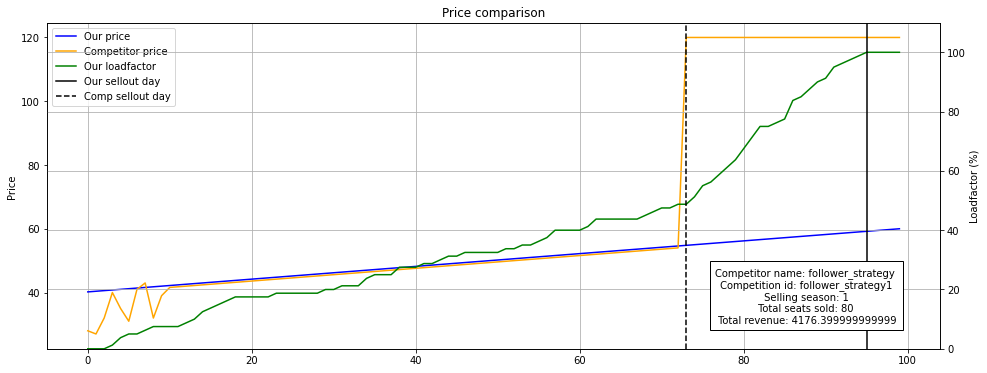

In [110]:
competition_id = 'follower_strategy1'
selling_season = 1

plot_price_and_loadfactor(competition_results_df, competition_id, selling_season)

In [112]:
# test simulation
competition_results_df = pd.DataFrame(columns=[
    'competition_id',
    'selling_season', 
    'selling_period', 
    'competitor_id', 
    'price_competitor', 
    'price', 
    'demand', 
    'competitor_has_capacity', 
    'revenue'
])

selling_season = 1
last_demand = 0
last_comp_price = 50
our_strat = 'fixed_price'
comp_strat = 'highstart_randomranges'

simulator = CreateAirlineSimulation()
our_strategy = OurStrategySimulation(our_strat, 50)
comp_strategy = CompStrategySimulation(comp_strat)

for period in range(100):

    our_price = our_strategy.pick_pricepoint(last_demand=last_demand, comp_has_capacity=simulator.comp_stock > 0)
    comp_price = comp_strategy.pick_pricepoint(last_comp_price=last_comp_price)

    if simulator.comp_stock <= 0:
        comp_price = 120
        
    log_period = simulator.period
    log_comp_stock = simulator.comp_stock > 0
    
    our_demand, comp_demand = simulator.simulate_demand(our_price=our_price, comp_price=comp_price)

    add_row = {
        'competition_id': our_strat + str(selling_season),
        'selling_season': 1, 
        'selling_period': log_period, 
        'competitor_id': comp_strat, 
        'price_competitor': comp_price, 
        'price': our_price, 
        'demand': our_demand[0], 
        'competitor_has_capacity': log_comp_stock, 
        'revenue': our_demand[0] * our_price
    }

    competition_results_df = competition_results_df.append(add_row, ignore_index=True)
    
    # Update input for price stratagies
    last_demand = our_demand
    last_comp_price = our_price  # for comp strategy

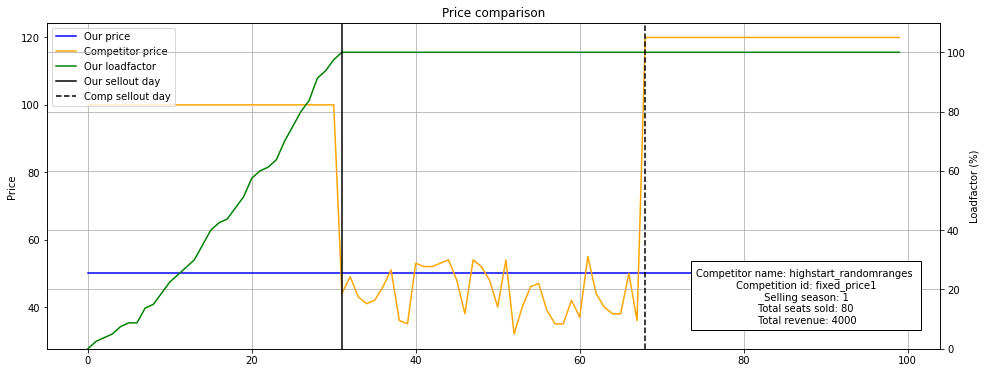

In [113]:
competition_id = 'fixed_price1'
selling_season = 1

plot_price_and_loadfactor(competition_results_df, competition_id, selling_season)

In [134]:
# test simulation
competition_results_df = pd.DataFrame(columns=[
    'competition_id',
    'selling_season', 
    'selling_period', 
    'competitor_id', 
    'price_competitor', 
    'price', 
    'demand', 
    'competitor_has_capacity', 
    'revenue'
])

selling_season = 1
last_demand = [0]
last_comp_price = 50
our_strat = 'linear_demand'
comp_strat = 'random_ranges'

simulator = CreateAirlineSimulation()
our_strategy = OurStrategySimulation(our_strat, 50)
comp_strategy = CompStrategySimulation(comp_strat)

for period in range(100):

    our_price = our_strategy.pick_pricepoint(last_demand=last_demand[0], comp_has_capacity=simulator.comp_stock > 0)
    comp_price = comp_strategy.pick_pricepoint(last_comp_price=last_comp_price)

    if simulator.comp_stock <= 0:
        comp_price = 120
        
    log_period = simulator.period
    log_comp_stock = simulator.comp_stock > 0
    
    our_demand, comp_demand = simulator.simulate_demand(our_price=our_price, comp_price=comp_price)

    add_row = {
        'competition_id': our_strat + str(selling_season),
        'selling_season': 1, 
        'selling_period': log_period, 
        'competitor_id': comp_strat, 
        'price_competitor': comp_price, 
        'price': our_price, 
        'demand': our_demand[0], 
        'competitor_has_capacity': log_comp_stock, 
        'revenue': our_demand[0] * our_price
    }

    competition_results_df = competition_results_df.append(add_row, ignore_index=True)
    
    # Update input for price stratagies
    last_demand = our_demand
    last_comp_price = our_price  # for comp strategy

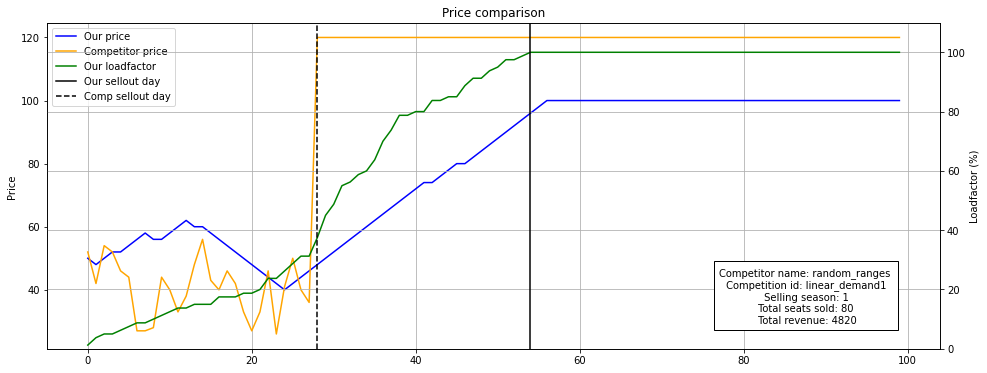

In [135]:
competition_id = 'linear_demand1'
selling_season = 1

plot_price_and_loadfactor(competition_results_df, competition_id, selling_season)

In [ ]:
## tes multiple

In [136]:
competition_results_df = pd.DataFrame(columns=[
    'competition_id',
    'selling_season', 
    'selling_period', 
    'competitor_id', 
    'price_competitor', 
    'price', 
    'demand', 
    'competitor_has_capacity', 
    'revenue'
])

our_strat = 'fixed_price'
comp_strat = 'highstart_randomranges'

simulator = CreateAirlineSimulation()
our_strategy = OurStrategySimulation(our_strat, 50)
comp_strategy = CompStrategySimulation(comp_strat)

for selling_season in range(1, 4):
    
    last_demand = 0
    last_comp_price = 50
    
    for period in range(100):

        our_price = our_strategy.pick_pricepoint(last_demand=last_demand, comp_has_capacity=simulator.comp_stock > 0)
        comp_price = comp_strategy.pick_pricepoint(last_comp_price=last_comp_price)

        if simulator.comp_stock <= 0:
            comp_price = 120

        log_period = simulator.period
        log_comp_stock = simulator.comp_stock > 0

        our_demand, comp_demand = simulator.simulate_demand(our_price=our_price, comp_price=comp_price)

        add_row = {
            'competition_id': our_strat + str(selling_season),
            'selling_season': selling_season, 
            'selling_period': log_period, 
            'competitor_id': comp_strat, 
            'price_competitor': comp_price, 
            'price': our_price, 
            'demand': our_demand[0], 
            'competitor_has_capacity': log_comp_stock, 
            'revenue': our_demand[0] * our_price
        }

        competition_results_df = competition_results_df.append(add_row, ignore_index=True)

        # Update input for price stratagies
        last_demand = our_demand
        last_comp_price = our_price  # for comp strategy

In [138]:
pd.set_option('max.rows', 300)
competition_results_df

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,revenue
0,fixed_price0,0,1,highstart_randomranges,100,50,2,True,100
1,fixed_price0,0,2,highstart_randomranges,100,50,3,True,150
2,fixed_price0,0,3,highstart_randomranges,100,50,5,True,250
3,fixed_price0,0,4,highstart_randomranges,100,50,2,True,100
4,fixed_price0,0,5,highstart_randomranges,100,50,0,True,0
5,fixed_price0,0,6,highstart_randomranges,100,50,3,True,150
6,fixed_price0,0,7,highstart_randomranges,100,50,3,True,150
7,fixed_price0,0,8,highstart_randomranges,100,50,3,True,150
8,fixed_price0,0,9,highstart_randomranges,100,50,4,True,200
9,fixed_price0,0,10,highstart_randomranges,100,50,3,True,150


In [162]:
# Baselines
competition_results_df = pd.DataFrame(columns=[
    'our_strategy',
    'competition_id',
    'selling_season', 
    'selling_period', 
    'competitor_id', 
    'price_competitor', 
    'price', 
    'demand', 
    'competitor_has_capacity', 
    'revenue'
])

simulator = CreateAirlineSimulation()

for strategy in ["fixed_price", "linear_increase", "linear_demand"]:
    
    print(f'Start simulations for strategy: {strategy}')
    
    our_strat = strategy
    if our_strat == 'fixed_price':
        our_strategy = OurStrategySimulation(our_strat, 65)
    elif our_strat == 'linear_increase':
        our_strategy = OurStrategySimulation(our_strat, 50, 80)
    elif our_strat == 'linear_demand':
        our_strategy = OurStrategySimulation(our_strat, 60)
    
    for selling_season in range(1, 301):  # episode
        
        # Competitor strategy is different every time
        comp_strat = np.random.choice(["random_ranges", "highstart_randomranges", "follower_strategy"])
        comp_strategy = CompStrategySimulation(comp_strat)
        
        if selling_season % 100 == 0:
            print(f'Starting season: {selling_season}')
        
        last_demand = [0]
        last_comp_price = 50
        
        for period in range(100):
            
            our_price = our_strategy.pick_pricepoint(last_demand=last_demand[0], comp_has_capacity=simulator.comp_stock > 0)
            comp_price = comp_strategy.pick_pricepoint(last_comp_price=last_comp_price)

            if simulator.comp_stock <= 0:
                comp_price = 120

            log_period = simulator.period
            log_comp_stock = simulator.comp_stock > 0

            our_demand, comp_demand = simulator.simulate_demand(our_price=our_price, comp_price=comp_price)

            add_row = {
                'our_strategy': our_strat,
                'competition_id': our_strat + str(selling_season),
                'selling_season': selling_season, 
                'selling_period': log_period, 
                'competitor_id': comp_strat, 
                'price_competitor': comp_price, 
                'price': our_price, 
                'demand': our_demand[0], 
                'competitor_has_capacity': log_comp_stock, 
                'revenue': our_demand[0] * our_price
            }

            competition_results_df = competition_results_df.append(add_row, ignore_index=True)

            # Update input for price stratagies
            last_demand = our_demand
            last_comp_price = our_price  # for comp strategy

Start simulations for strategy: fixed_price
Starting season: 100
Starting season: 200
Starting season: 300
Start simulations for strategy: linear_increase
Starting season: 100
Starting season: 200
Starting season: 300
Start simulations for strategy: linear_demand
Starting season: 100
Starting season: 200
Starting season: 300


In [163]:
# Check revenue per season
revenue_ps = (competition_results_df
              .groupby(['competition_id', 'our_strategy', 'competitor_id', 'selling_season'])
              .agg({'revenue': 'sum'})
              .reset_index()
             )

revenue_ps.sample(5)

,competition_id,our_strategy,competitor_id,selling_season,revenue
244,fixed_price49,fixed_price,highstart_randomranges,49,5200.0
323,linear_demand12,linear_demand,highstart_randomranges,12,5042.0
151,fixed_price235,fixed_price,highstart_randomranges,235,5200.0
214,fixed_price292,fixed_price,highstart_randomranges,292,5200.0
210,fixed_price289,fixed_price,highstart_randomranges,289,5200.0


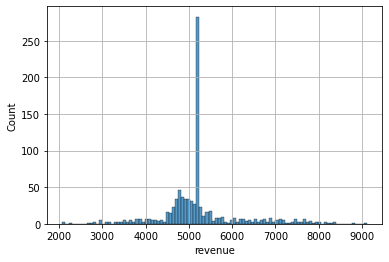

In [164]:
sns.histplot(revenue_ps['revenue'], bins=100)
plt.grid()

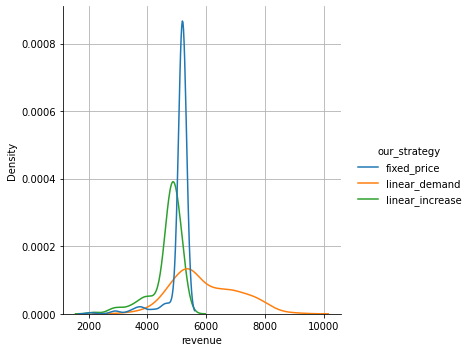

In [165]:
sns.displot(data=revenue_ps, x='revenue', hue='our_strategy', kind="kde")
plt.grid()

In [166]:
revenue_ps.groupby('our_strategy')['revenue'].mean()

our_strategy
fixed_price        5072.600000
linear_demand      5961.286667
linear_increase    4672.787667
Name: revenue, dtype: float64

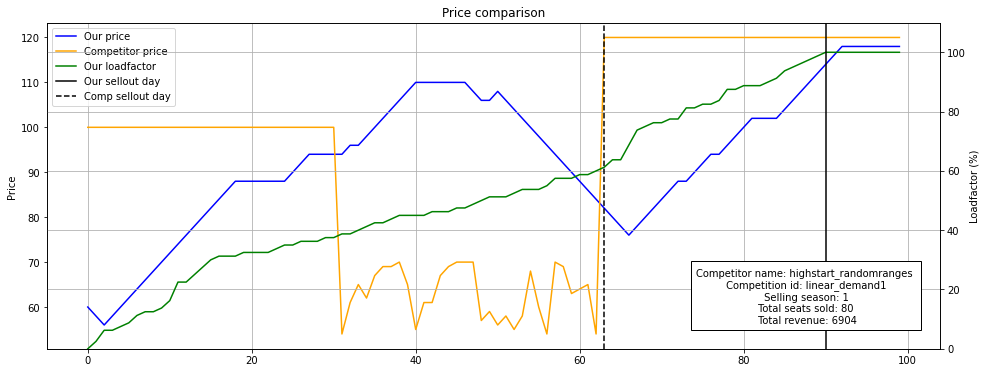

In [167]:
competition_id = 'linear_demand1'
selling_season = 1

plot_price_and_loadfactor(competition_results_df, competition_id, selling_season)